## **FORMULACIÓN PROBLEMA REDES**

En una red de distribución se tienen 3 origenes y 5 destinos. Los nodos de origen tienen una capacidad de envío y los nodos de destino tienen una demanda. Cada arco tiene asociado un costo fijo de enviar y un costo variable. Adicionalmente, hay arcos que no están disponibles. Escriba un modelo de optimización para decidir la cantidad se debe enviar de un nodo a otros minimizando los costos.

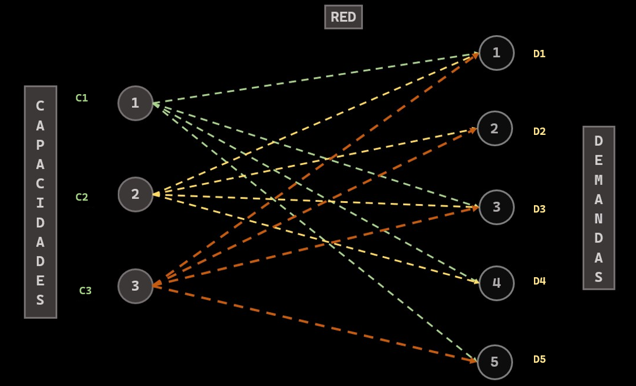

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

| COSTO_VARIABLE | 1   | 2  | 3  | 4  | ... |
| -------------- | --: | -: | -: | -: | -:  |
| 1              | 6   | 20 | 14 | 18 | ... |
| 2              | 12  | 6  | 19 | 12 | ... |
| ...            | ... |... |... |... | ... |

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

| COSTO_FIJO | 1   | 2   | 3    | 4   | ... |
| ---------- | --: | --: | ---: | --: | --: |
| 1          | 32  | 48  | 74   | 11  | ... |
| 2          | 12  | 61  | 191  | 52  | ... |
| ...        | ... |...  |...   |...  | ... |

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

| BINARIO_NODOS | 1   | 2   | 3   | 4  | ... |
| ------------- | --: | --: | --: | -: | --: |
| 1             | 1   | 0   | 1   | 1  | ... |
| 2             | 1   | 1   | 1   | 1  | ... |
| ...           | ... |...  |...  |... | ... |

**RESTRICCIONES ADICIONALES**
1. Origen 3 no puede enviarle a 5 y a 1 al tiempo
2. Origen 3 puede enviarle máximo a 2 destinos
3. Si origen 1 envía a destino 20, entonces deberá enviar a destino 3 mínimo 7 unidades
4. Si el origen 13, le envia a 5 y 7, pero no a 15, entonces no le podra a 10
5. Si origen 2 envía a más de 4 destino, se penalizará en 1000 la funcion objetivo
6. Lo recibido por cada destino debe ser como mínimo igual a su faltante

In [19]:
import pandas
from docplex.mp.model import Model
import plotly.graph_objects as go

In [20]:
df_capacidades = pandas.read_excel("./data.xlsx", sheet_name="capacidades", index_col=0)
df_demandas = pandas.read_excel("./data.xlsx", sheet_name="demandas", index_col=0)
df_costo_fijo = pandas.read_excel("./data.xlsx", sheet_name="costo_fijo", index_col=0)
df_costo_variable = pandas.read_excel("./data.xlsx", sheet_name="costo_variable", index_col=0)
df_binario = pandas.read_excel("./data.xlsx", sheet_name="binario", index_col=0)

**Conjuntos**

$$ O: \text{Origenes} = \{1, 2,...,30\} $$
$$ D: \text{Destinos} = \{1, 2,...,50\} $$

In [21]:
ORIGENES = df_capacidades.index.to_list()
DESTINOS = df_demandas.index.to_list()

**Parámetros**

$$ \text{COSTO\_FIJO}_{od}: \text{costo fijo de enviar del origen } o\in O \text{ al destino } d\in D $$
$$ \text{COSTO\_VARIABLE}_{od}: \text{costo variable de enviar del origen } o\in O \text{ al destino } d\in D $$
$$ \text{BINARIO\_NODOS}_{od}: \left\{ \begin{array}{cl}
1\text{ Si el origen } o\in O \text{ puede enviar al destino } d\in D \\
0\text{ dlc}
\end{array} \right. $$
$$ \text{Capacidad}_{o}: \text{capacidad del origen } o\in O $$
$$ \text{Demanda}_{d}: \text{demanda del destino } d\in D $$

In [22]:
model = Model()

**Variables de decisión**

$$ x_{od} = \left\{ \begin{array}{cl}
1:\text{Si decido ir del origen } o\in O \text{ al destino } d\in D \\
0:\text{dlc}
\end{array} \right. $$
$$ w_{od}: \text{cantidad enviada del origen } o\in O \text{ al destino } d\in D $$
$$ F_{d}: \text{faltantes del destino } d\in D $$

In [23]:
X = model.binary_var_dict([(o, d) for o in ORIGENES for d in DESTINOS], name="X")
W = model.continuous_var_dict([(o, d) for o in ORIGENES for d in DESTINOS], name="W")
F = model.continuous_var_dict(DESTINOS, name="F")
PHI = model.binary_var()

**Función Objetivo**

$$ \text{minimizar } \text{FO} = \sum_{o\in O}\sum_{d\in D} \text{COSTO\_FIJO}_{od} \times x_{od} + \sum_{o\in O}\sum_{d\in D} \text{COSTO\_VARIABLE}_{od} \times w_{od} + \mathcal{M} \times \sum_{d\in D} F_{d} + 100 * \phi $$

In [24]:
costo_fijo = model.sum(df_costo_fijo.loc[o, d] * X[o, d] for o in ORIGENES for d in DESTINOS)
costo_variable = model.sum(df_costo_variable.loc[o, d] * W[o, d] for o in ORIGENES for d in DESTINOS)
faltantes_totales = model.sum(F[d] for d in DESTINOS)
# model.minimize(costo_fijo + costo_variable + 10000 * faltantes_totales)

sense = "min"
exprs = [faltantes_totales, costo_fijo + costo_variable]
priorities = [2, 1]
weights = [1, 1]

model.set_multi_objective(sense, exprs, priorities, weights)

**Restricciones**

$$ \forall d \in D:\sum_{o\in O}w_{od} + F_{d} \ge \text{Demanda}_{d} $$

In [25]:
## Demanda
for d in DESTINOS:
    model.add_constraint(model.sum(W[o,d] for o in ORIGENES) + F[d]>= df_demandas.loc[d, "DEMANDA"])

$$ \forall o \in O:\sum_{d\in D}w_{od} \le \text{Capacidad}_{o} $$

In [26]:
## Capacidad
for o in ORIGENES:
    model.add_constraint(model.sum(W[o,d] for d in DESTINOS) <= df_capacidades.loc[o, "CAPACIDAD"])

$$ \forall o \in O \quad\forall d\in D:x_{od}\le \text{BINARIO\_NODOS}_{od} $$

In [27]:
## Parámetro binario
for o in ORIGENES:
    for d in DESTINOS:
        model.add_constraint(X[o, d] <= df_binario.loc[o, d])

$$ \forall o \in O \quad\forall d\in D:w_{od} \le \mathcal{M} \times x_{od} $$

In [28]:
## Relación decisión de envío y cantidad enviada
for o in ORIGENES:
    for d in DESTINOS:
        model.add_constraint(W[o,d] <= 100 * X[o, d])

$$ \forall d \in D:\sum_{o\in O}w_{od} \ge F_{d} $$

In [29]:
for d in DESTINOS:
    model.add_constraint(model.sum(W[o, d] for o in ORIGENES) >= F[d])

$$ x_{31} + x_{35} \le 1 $$

In [30]:
## Origen 3 no puede enviarle a 5 y a 1 al tiempo
model.add_constraint(X["O_03", "D_01"] + X["O_03", "D_05"] <= 1)

docplex.mp.LinearConstraint[](X_O_03_D_01+X_O_03_D_05,LE,1)

$$ \sum_{d\in D} w_{3d} \le  2 $$

In [31]:
## Origen 3 puede enviarle máximo a 2
model.add_constraint(model.sum(X["O_03", d] for d in DESTINOS) <= 2)

docplex.mp.LinearConstraint[](X_O_03_D_01+X_O_03_D_02+X_O_03_D_03+X_O_03_D_04+X_O_03_D_05+X_O_03_D_06+X_O_03_D_07+X_O_03_D_08+X_O_03_D_09+X_O_03_D_10+X_O_03_D_11+X_O_03_D_12+X_O_03_D_13+X_O_03_D_14+X_O_03_D_15+X_O_03_D_16+X_O_03_D_17+X_O_03_D_18+X_O_03_D_19+X_O_03_D_20+X_O_03_D_21+X_O_03_D_22+X_O_03_D_23+X_O_03_D_24+X_O_03_D_25+X_O_03_D_26+X_O_03_D_27+X_O_03_D_28+X_O_03_D_29+X_O_03_D_30+X_O_03_D_31+X_O_03_D_32+X_O_03_D_33+X_O_03_D_34+X_O_03_D_35+X_O_03_D_36+X_O_03_D_37+X_O_03_D_38+X_O_03_D_39+X_O_03_D_40+X_O_03_D_41+X_O_03_D_42+X_O_03_D_43+X_O_03_D_44+X_O_03_D_45+X_O_03_D_46+X_O_03_D_47+X_O_03_D_48+X_O_03_D_49+X_O_03_D_50,LE,2)

$$ w_{1,3} \ge 7 - \mathcal{M} * (1 - x_{1,20})

In [32]:
model.add_indicator(X["O_01", "D_20"], W["O_01", "D_01"] >= 7, active_value=1)

docplex.mp.constr.IndicatorConstraint[](X_O_01_D_20,W_O_01_D_01>=7,true=1)

$$ 3 - (x_{13,5} + x_{13,7} + (1 - x_{13,15})) \geq x_{13,10}  $$

In [33]:
model.add(1 - model.logical_and((X["O_13", "D_05"] == 1), (X["O_13", "D_07"] == 1), (X["O_13", "D_15"] == 0)) >= X["O_13", "D_30"])

docplex.mp.LinearConstraint[](-_and3054+1,GE,X_O_13_D_30)

$$ \mathcal{M} \phi \le \mathcal{M} + (\sum_{d\in D} x_{2d}-3.5) $$
$$ \mathcal{M} \phi \ge (\sum_{d\in D} x_{2d}-3.5) $$

In [34]:
## Si origen 2 envía a más de 3 destino, se penalizará en 100 la funcion objetivo
for d1 in DESTINOS:
    for d2 in DESTINOS:
            model.add_if_then(model.sum(X["O_02", d] for d in DESTINOS) >= 4, PHI == 1)

In [35]:
solution = model.solve(log_output=True)

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1

Multi-objective solve log . . .

Index  Priority  Blend          Objective      Nodes  Time (sec.)  DetTime (ticks)


    1         2      1   7.7500000000e+02          0         0.36            86.26
    2         1      1   5.2472200000e+03         32         4.59           953.22


In [36]:
fig = go.Figure()
fig.add_trace(go.Bar(x=DESTINOS, y=[sum(W[o, d].solution_value for o in ORIGENES) for d in DESTINOS], name="Envío"))
fig.add_trace(go.Bar(x=DESTINOS, y=[F[d].solution_value for d in DESTINOS], name="Faltantes"))


fig.update_layout(
    title=f"<b>CANTIDAD RECIBIDA Y FALTANTES DESTINOS<br />Costo Fijo: {costo_fijo.solution_value:.2f} - Costo Variable: {costo_variable.solution_value:.2f}<br />Faltantes Totales: {faltantes_totales.solution_value:.0f}</b>",
    xaxis=dict(title="Destinos"),
    yaxis=dict(title="Cantidades"),
    barmode="group",
    width=1200,
    template="ggplot2",
)

fig.show()